# SCALE tutorial

### Read alignment and peak calling

** We used Kundaje pipeline (https://github.com/kundajelab/atac_dnase_pipelines) for aligning pair ended reads to hg19 and removing duplicates as scABC (https://github.com/SUwonglab/scABC/) did **  
bds_scr [SCR_NAME] atac.bds -align -species hg19 -species_file [SPECIES_FILE_PATH] -nth [NUM_THREADS] -fastq1_1 [READ_PAIR1] -fastq1_2 [READ_PAIR2]

** The resulting bam files were merged using samtools. **  
samtools merge [AGGREGATE_BAM] *.trim.PE2SE.nodup.bam  

** The merged bam file was then used as input into MACS2 to call merged peaks for later analysis, using the Kundaje pipeline again.**  
bds_scr [SCR_NAME] atac.bds -species hg19 -species_file [SPECIES_FILE_PATH] -nth [NUM_THREADS] -se -filt_bam [AGGREGATE_BAM]


### Preprocessing
from scale.utils import sample_filter, peak_filter, cell_filter  
** We filtered peaks that presented in >= 10 cells with >= 2 reads by peak_filter function **  
data = peak_filter(data)    
** We filtered cells that >= number of peaks / 50 by cell_filter function **  
data = cell_filter(data)  
** Or combine peak_filter and cell_filter **  
data = sample_filter(data)

# Get Started from a scATAC-seq data matrix

## Running SCALE model 
e.g. SCALE -d data_matrix -k cluster_number -o output_dir  
** input:**  
peak count matrix

** output: **  
1. feature.txt 
2. cluster_assignments.txt
3. impute_data.txt
4. model.pt

In [24]:
# !SCALE.py -d data.txt -k 6 -e 1000 -o output

## Analysis workflow
1. visualization of latent feature embeddings
2. confusion matrix
3. data imputation analysis
4. cell type specific elements

In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from scale.plot import plot_confusion_matrix, plot_embedding, plot_heatmap
from scale.utils import read_labels, reassign_cluster_with_ref, pairwise_pearson
from scale.specifity import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# plt.rcParams['savefig.dpi'] = 300
# plt.rcParams['figure.dpi'] = 300

In [8]:
input_dir = '../data/'
out_dir = '../output/'

In [10]:
feature_file = out_dir+'feature.txt'
assignments_file = out_dir+'cluster_assignments.txt'
impute_data_file = out_dir+'imputed_data.txt'

raw_data_file = input_dir + 'data.txt'
reference_file = input_dir + 'labels.txt'

In [11]:
raw_data = pd.read_csv(raw_data_file, sep='\t', index_col=0)
imputed_data = pd.read_csv(impute_data_file, sep='\t', index_col=0)

In [20]:
ref, classes, le = read_labels(reference_file, return_enc=True)
classes = ['Mono', 'LMPP', 'LSC_SU353', 'LSC_SU070', 'Blast_SU353', 'Blast_SU070']
classes_ = le.transform(classes) # class number name

pred, pred_classes = read_labels(assignments_file)
pred = reassign_cluster_with_ref(pred, ref)

y = le.inverse_transform(ref)
pred_ = le.inverse_transform(pred)
y_pred = np.array(['cluster'+str(c+1) for c in pred])
# _, assignments = cluster_acc(assignments, ref) # reassignment cluster

## 1. Feature embedding
different color representing ground truth cell types

In [21]:
feature = pd.read_csv(feature_file, sep='\t', index_col=0, header=None)

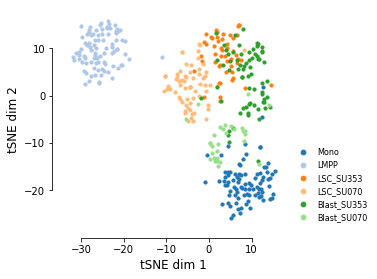

In [22]:
legend_params = {'loc':'right', 'ncol':1, 'bbox_to_anchor':(1.4, 0.2), 'fontsize':8, 'markerscale':1.5}
plot_embedding(feature, y, classes=classes, markersize=10, figsize=(4,4), legend_params=legend_params )

## 2. Confusion matrix 
cluster assignments compared with ground truth

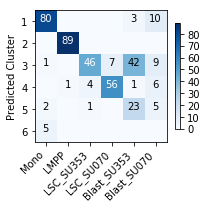

In [23]:
cm = confusion_matrix(pred_, y, labels=classes)
plot_confusion_matrix(cm, classes, pred_classes+1, 
                    title='', normalize=False, figsize=(3,3), show_cbar=True)

## 3. Imputation

#### Cells correlation of imputed data with meta-cells of each cell type

In [27]:
peak_corr = []
for c in classes:
    cells = np.where(y==c)[0]
    peak_corr.append(pairwise_pearson(imputed_data.iloc[:, cells].T, raw_data.iloc[:, cells].sum(1)))

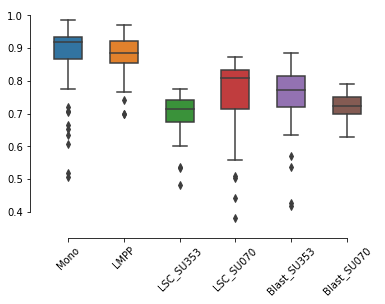

In [34]:
g = sns.boxplot(data=peak_corr, width=0.5)
sns.despine(offset=10, trim=True)
g.set_xticklabels(classes, rotation=45)
plt.show()

## 4. Cell type specific peaks

In [35]:
score_mat = mat_specificity_score(imputed_data, pred)

In [12]:
peak_index, peak_labels = cluster_specific(score_mat, classes=classes_, top=200);print(len(peak_index))
row_labels = ['cluster'+str(c+1) for c in peak_labels]
# f = open(out_dir+'specific_peaks.txt', 'w')
# for peak in imputed_data.index[peak_index].values:
#     f.write(peak.replace('_', '\t')+'\n')

1012


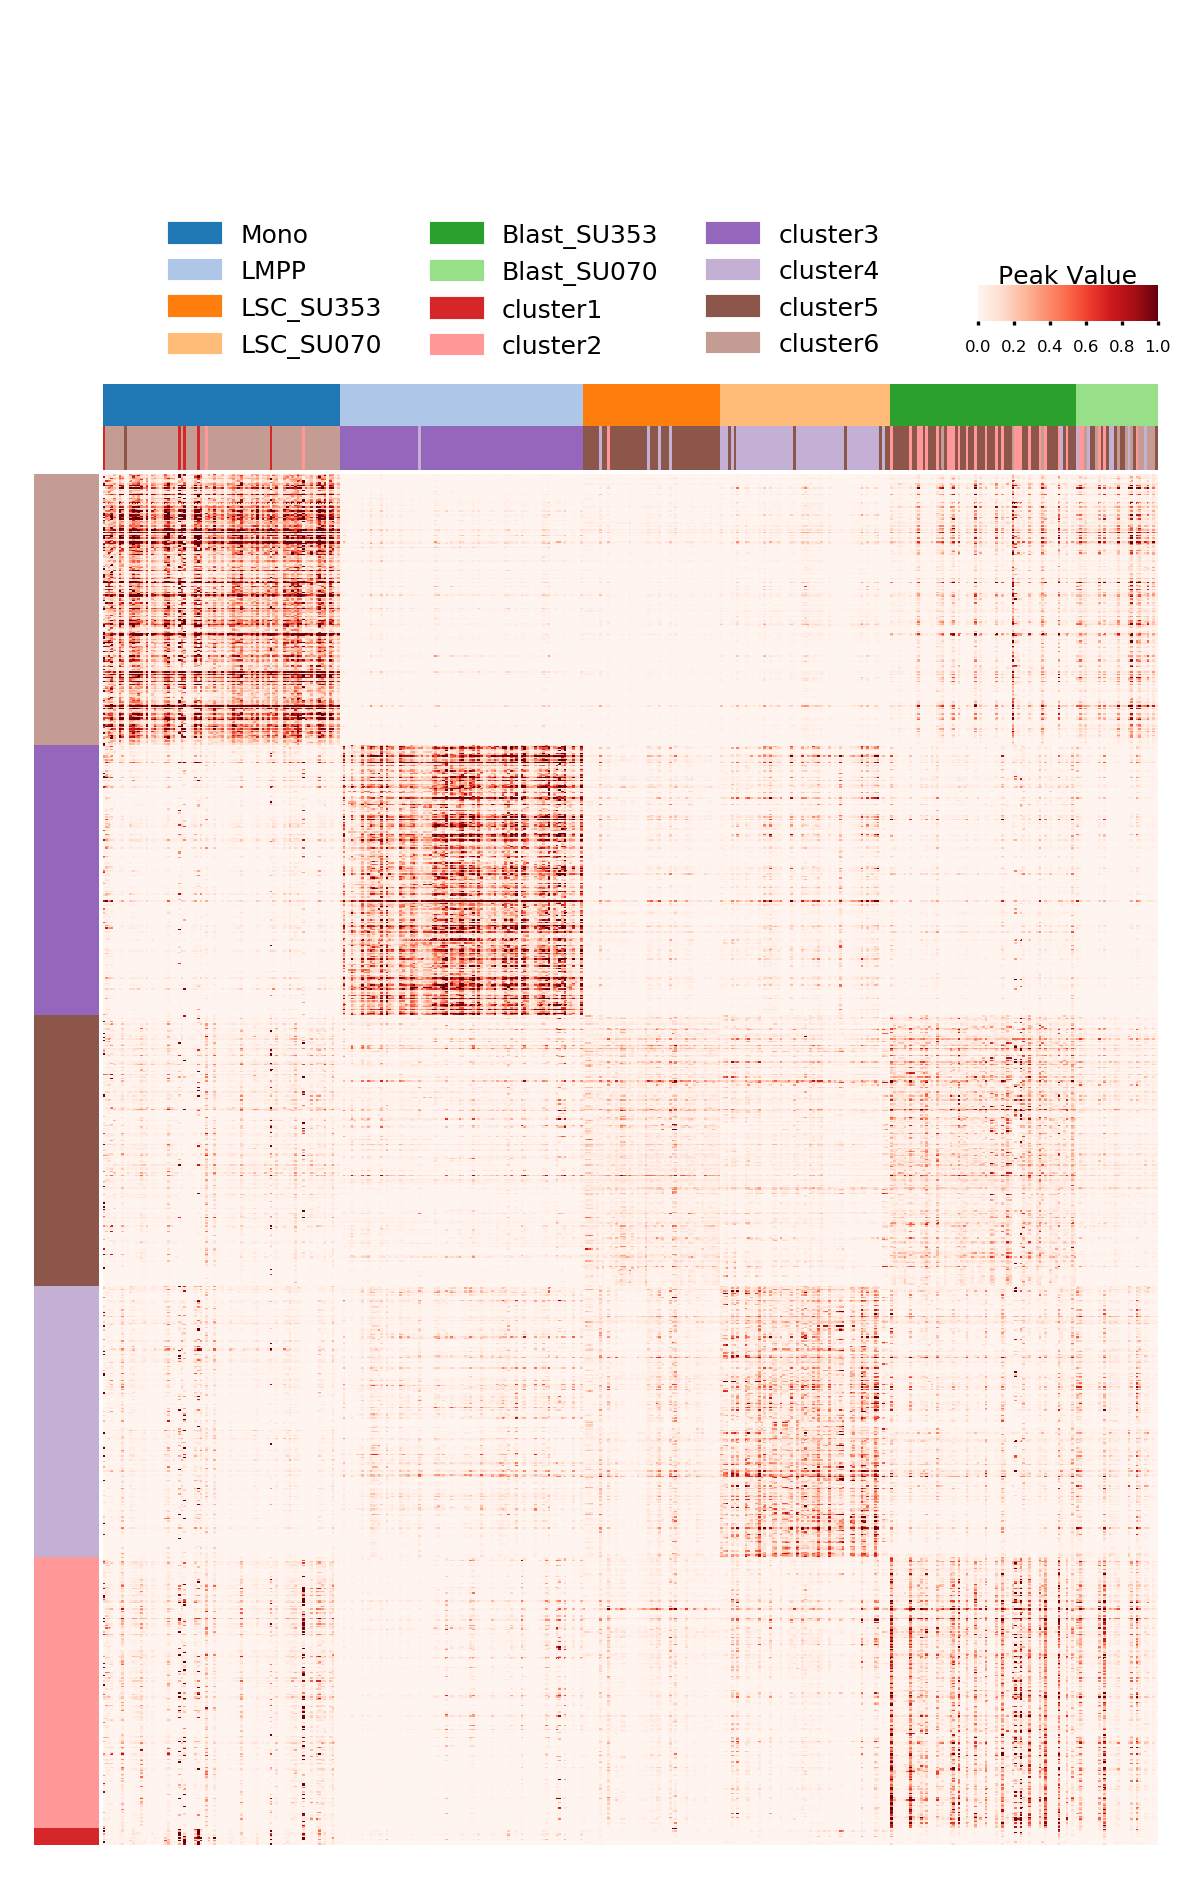

In [13]:
plot_heatmap(imputed_data.iloc[peak_index], y=y, classes=classes, y_pred=y_pred, row_labels=row_labels, 
             ncol=3,cmap='Reds', vmax=1, row_cluster=False, legend_font=6, cax_title='Peak Value',
             figsize=(6, 8), bbox_to_anchor=(0.4, 1.2), position=(0.8, 0.76, 0.1, 0.015))